In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
data_path = '/content/drive/MyDrive/dataset'
os.listdir(data_path)
phrase_folder='/content/drive/MyDrive/dataset/processed_phrases'
noise_folder='/content/drive/MyDrive/dataset/processed_noise'

In [ ]:
phrase_files = []
for root, dirs, files in os.walk(phrase_folder):
    for file in files:
        if file.endswith('.wav'):
            phrase_files.append(os.path.join(root, file))

In [ ]:
noise_files = []
for root, dirs, files in os.walk(noise_folder):
    for file in files:
        if file.endswith('.wav'):  # or other audio formats you have
            noise_files.append(os.path.join(root, file))

In [ ]:
import numpy as np
import librosa
import matplotlib.pyplot as plt

In [ ]:
def normalize_audio(audio):
    # Normalize audio to be in range [-1, 1]
    max_val = np.max(np.abs(audio))
    if max_val == 0:
        return audio
    return audio / max_val

In [ ]:
def trim_silence(audio, sr, top_db=25):
    trimmed_audio, index = librosa.effects.trim(audio, top_db=top_db)
    return trimmed_audio

In [ ]:
def load_preprocess_label(dataset_path, subfolder):
    data = []
    folder_path = os.path.join(dataset_path, subfolder)

    for label in os.listdir(folder_path):
        label_folder = os.path.join(folder_path, label)
        if os.path.isdir(label_folder):
            for file in os.listdir(label_folder):
                if file.endswith('.wav'):
                    file_path = os.path.join(label_folder, file)
                    audio, sr = librosa.load(file_path, sr=None)
                    norm_audio = normalize_audio(audio)
                    trimmed_audio = trim_silence(norm_audio, sr)
                    data.append((trimmed_audio, sr, label))
    return data

In [ ]:
processed_phrase = load_preprocess_label(data_path, subfolder='processed_phrases')


In [ ]:
processed_noise = load_preprocess_label(data_path, subfolder='')

In [ ]:
for i, (audio, sr, label) in enumerate(processed_noise):  # or processed_phrase
    print(f"Sample {i}: audio shape = {audio.shape}, sample rate = {sr}, label = {label}")

Sample 0: audio shape = (166069,), sample rate = 16000, label = processed_noise
Sample 1: audio shape = (170899,), sample rate = 16000, label = processed_noise
Sample 2: audio shape = (165698,), sample rate = 16000, label = processed_noise
Sample 3: audio shape = (167927,), sample rate = 16000, label = processed_noise


In [ ]:
import random

def add_noise(audio, noise, snr_db=10):
    # Calculate RMS of audio and noise
    rms_audio = np.sqrt(np.mean(audio**2))
    rms_noise = np.sqrt(np.mean(noise**2))

    # Calculate desired noise RMS for given SNR (signal-to-noise ratio)
    desired_rms_noise = rms_audio / (10**(snr_db / 20))

    # Scale noise to desired RMS
    noise = noise * (desired_rms_noise / (rms_noise + 1e-10))

    # Add noise (trim noise if longer than audio)
    noisy_audio = audio + noise[:len(audio)]

    # Optional: normalize result to prevent clipping
    max_val = np.max(np.abs(noisy_audio))
    if max_val > 1:
        noisy_audio = noisy_audio / max_val

    return noisy_audio

def augment_audio_balanced(data, noise_data, max_aug_per_audio=4):
    augmented_data = []
    augmented_labels = []

    for audio, sr, label in data:
        # Add original
        augmented_data.append(audio)
        augmented_labels.append(label)

        # Add noise augmentation once per audio
        noise_audio, noise_sr, _ = random.choice(noise_data)
        # Skip resampling if sample rates match
        if noise_sr != sr:
            noise_audio = librosa.resample(noise_audio, orig_sr=noise_sr, target_sr=sr)
        noisy_audio = add_noise(audio, noise_audio, snr_db=random.uniform(5, 15))
        augmented_data.append(noisy_audio)
        augmented_labels.append(label)
        augmentations_done = 1
        while augmentations_done < max_aug_per_audio:
            aug_audio = audio.copy()
            aug_type = random.choice(['speed', 'pitch', 'shift', 'volume'])

            if aug_type == 'speed':
                factor = random.uniform(0.8, 1.2)
                aug_audio = librosa.effects.time_stretch(aug_audio, rate=factor)

            elif aug_type == 'pitch':
                steps = random.randint(-2, 2)
                if steps != 0:
                    aug_audio = librosa.effects.pitch_shift(aug_audio, sr=sr, n_steps=steps)
            elif aug_type == 'shift':
                shift = random.randint(-1000, 1000)
                aug_audio = np.roll(aug_audio, shift)

            elif aug_type == 'volume':
                scale = random.uniform(0.7, 1.3)
                aug_audio = aug_audio * scale

            # Optional: trim silence again if needed
            aug_audio, _ = librosa.effects.trim(aug_audio, top_db=20)

            augmented_data.append(aug_audio)
            augmented_labels.append(label)
            augmentations_done += 1

    return augmented_data, augmented_labels

In [ ]:
# Usage
augmented_data, augmented_labels = augment_audio_balanced(processed_phrase, processed_noise)
print(f"Total samples after augmentation: {len(augmented_data)}")

Total samples after augmentation: 220


In [ ]:
def pad_or_truncate(audio, target_len=16000):
    if len(audio) > target_len:
        return audio[:target_len]
    else:
        return np.pad(audio, (0, target_len - len(audio)), mode='constant')

In [ ]:
padded_data = [pad_or_truncate(audio) for audio in augmented_data]

In [ ]:
def extract_mel_spectrogram(audio, sr=16000, n_mels=64, n_fft=1024, hop_length=512):
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db  # shape: (n_mels, time_frames)

# Extract features for all padded audios
mel_features = [extract_mel_spectrogram(audio) for audio in padded_data]

print(f"Extracted {len(mel_features)} Mel Spectrograms")
print(f"Shape of first feature: {mel_features[5].shape}")

Extracted 220 Mel Spectrograms
Shape of first feature: (64, 32)


In [ ]:
def plot_mel_spectrogram(mel_spec, sr=16000, hop_length=512, title='Mel Spectrogram'):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spec, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

Label: help_me


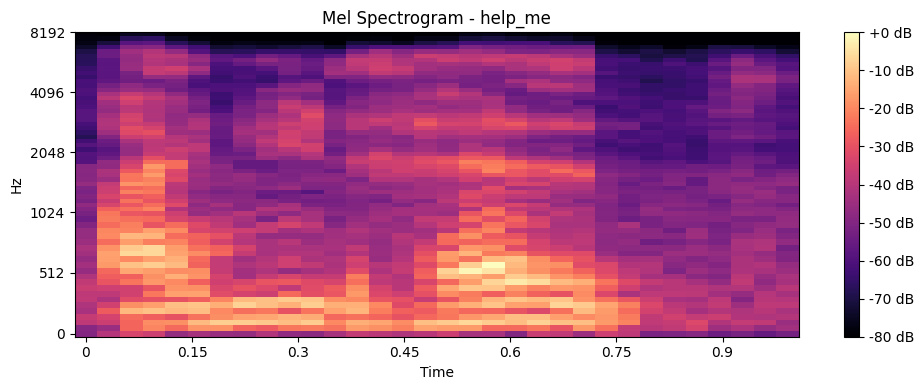

Label: madad_karo


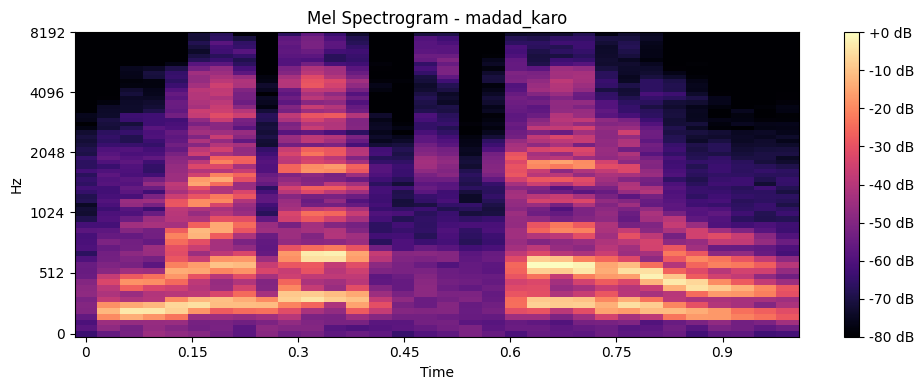

Label: help_me


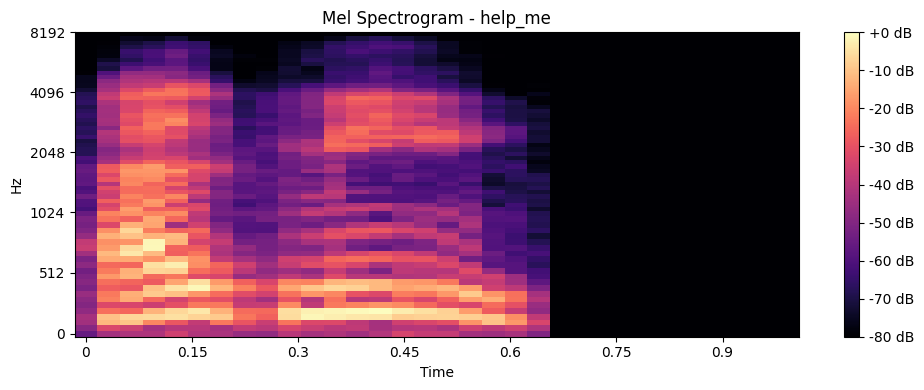

In [ ]:
def plot_random_mel_spectrograms(mel_features, labels, sr=16000, hop_length=512, num_plots=3):
    indices = random.sample(range(len(mel_features)), num_plots)
    for idx in indices:
        print(f"Label: {labels[idx]}")
        plot_mel_spectrogram(mel_features[idx], sr=sr, hop_length=hop_length, title=f"Mel Spectrogram - {labels[idx]}")

# Usage:
plot_random_mel_spectrograms(mel_features, augmented_labels, num_plots=3)

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Create label encoder and fit on all labels
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(augmented_labels)


In [ ]:
print(f"Example labels: {augmented_labels[60:75]}")
print(f"Encoded labels: {numeric_labels[60:75]}")
print(f"All classes: {label_encoder.classes_}")

Example labels: ['someone_help', 'someone_help', 'someone_help', 'someone_help', 'someone_help', 'help_me', 'help_me', 'help_me', 'help_me', 'help_me', 'help_me', 'help_me', 'help_me', 'help_me', 'help_me']
Encoded labels: [5 5 5 5 5 2 2 2 2 2 2 2 2 2 2]
All classes: ['anyone_there' 'bacha_lo' 'help_me' 'koi_hai_kya' 'madad_karo'
 'someone_help']


In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    mel_features,          # your input data
    numeric_labels,            # corresponding labels
    test_size=0.2,     # 20% data for testing
    random_state=42,   # ensures reproducibility
    stratify=numeric_labels    # keeps class distribution balanced
)
X_train1, X_val, y_train1, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42,stratify=y_train)

In [ ]:
X_train=np.array(X_train)
X_test=np.array(X_test)
y_train=np.array(y_train)
y_test=np.array(y_test)
X_train1=np.array(X_train1)
X_val=np.array(X_val)
y_train1=np.array(y_train1)
y_val=np.array(y_val)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_train1.shape, X_val.shape, y_train1.shape, y_val.shape

((176, 64, 32),
 (44, 64, 32),
 (176,),
 (44,),
 (140, 64, 32),
 (36, 64, 32),
 (140,),
 (36,))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
X_train_cnn = np.expand_dims(X_train, -1)
X_test_cnn = np.expand_dims(X_test, -1)
X_train1_cnn = np.expand_dims(X_train1, -1)
X_val_cnn = np.expand_dims(X_val, -1)

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 32, 1),kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

# model.add(Conv2D(128, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.001)))
# model.add(BatchNormalization())
# model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(len(label_encoder.classes_), activation='softmax',kernel_regularizer=regularizers.l2(0.001)))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 62, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 62, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 31, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 31, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 29, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 29, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 6, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 14, 6, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 5376)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       688,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 708,230 (2.70 MB)

 Trainable params: 708,038 (2.70 MB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
optimizer=Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

In [ ]:
history=model.fit(X_train1_cnn, y_train1, validation_data=(X_val_cnn, y_val), epochs=50, batch_size=32,)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.2378 - loss: 4.8513 - val_accuracy: 0.1944 - val_loss: 11.4558
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4813 - loss: 2.5476 - val_accuracy: 0.3056 - val_loss: 5.8243
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6832 - loss: 1.2111 - val_accuracy: 0.1944 - val_loss: 8.2165
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7760 - loss: 0.9960 - val_accuracy: 0.1667 - val_loss: 8.8603
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8036 - loss: 0.8296 - val_accuracy: 0.1389 - val_loss: 7.8270
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8300 - loss: 0.7687 - val_accuracy: 0.1389 - val_loss: 6.0966
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8803 - loss: 0.6916 - val_accuracy: 0.1389 - val_loss: 4.7808
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9493 - loss: 0.5105 - val_accuracy: 0.1667 - val_loss: 3.9024


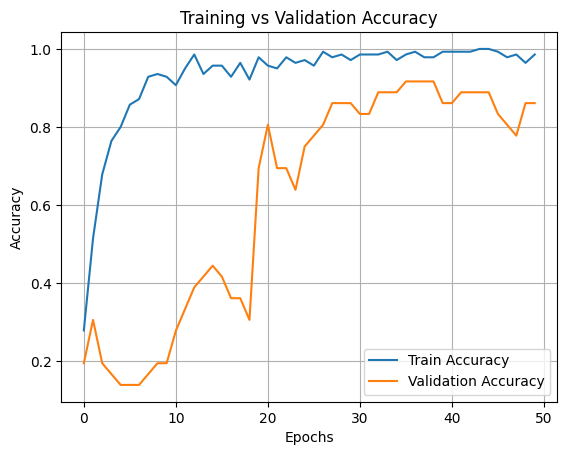

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

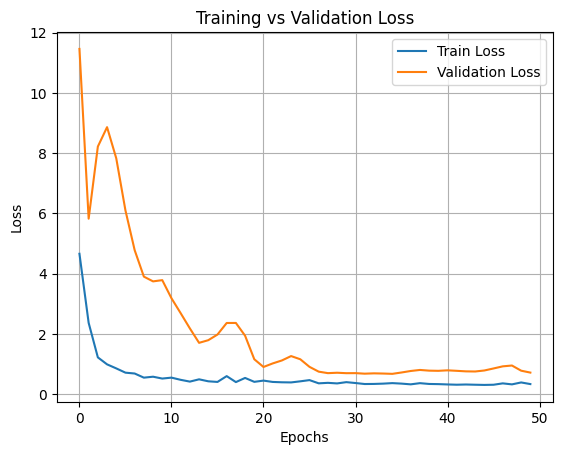

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(X_test_cnn, y_test, verbose=1)

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.8011 - loss: 1.2913
Test Accuracy: 0.7955
Test Loss: 1.3045


In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 381ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred_classes))
print(confusion_matrix(y_test, y_pred_classes))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83         6
           1       0.89      1.00      0.94         8
           2       0.62      1.00      0.77        10
           3       1.00      0.71      0.83         7
           4       0.83      0.71      0.77         7
           5       1.00      0.33      0.50         6

    accuracy                           0.80        44
   macro avg       0.86      0.77      0.77        44
weighted avg       0.85      0.80      0.78        44

[[ 5  0  1  0  0  0]
 [ 0  8  0  0  0  0]
 [ 0  0 10  0  0  0]
 [ 1  0  1  5  0  0]
 [ 0  0  2  0  5  0]
 [ 0  1  2  0  1  2]]


After running the cell above, you will be prompted to allow microphone access. Click "Allow" to start recording. The recording will automatically stop after 5 seconds.

In [ ]:
model.input_shape

(None, 64, 32, 1)